In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')
%matplotlib inline

Рассмотрим набор данных размерности $D$, чья реальная размерность значительно меньше наблюдаемой (назовём её $d$)
1. Для каждого значения $\hat{d}$ в интервале [1,D] построиv модель PCA с $\hat{d}$ главными компонентами.
2. Оцениv средний логарифм правдоподобия данных для каждой модели на генеральной совокупности, используя метод кросс-валидации с 3 фолдами.
3. Найдем модель, для которой он максимален, и внести в файл ответа число компонент в данной модели, т.е. значение $\hat{d}_{opt}$.

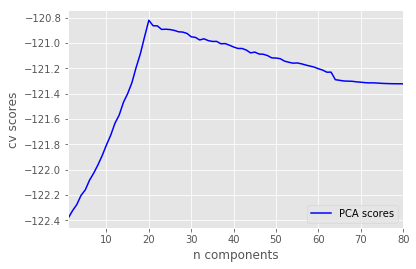

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score as cv_score

def plot_scores(d_scores):
    n_components = np.arange(1,d_scores.size+1)
    plt.plot(n_components, d_scores, 'b', label='PCA scores')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('cv scores')
    plt.legend(loc='lower right')
    plt.show()
    
def write_answer_1(optimal_d):
    with open("pca_answer1.txt", "w") as fout:
        fout.write(str(optimal_d))
        
data = pd.read_csv('../data/PCA1.csv')

d_scores = [cv_score(PCA(n_components=n), data).mean() for n in range(1, data.shape[1]+1)]

plot_scores(np.array(d_scores))

write_answer_1(max(zip(d_scores, range(1, len(d_scores)+1)))[1])

Рассмотрим ещё один набор данных размерности $D$, чья реальная размерность значительно меньше наблюдаемой (назовём её также $d$). От вас требуется:
1. Построим модель PCA с $D$ главными компонентами по этим данным.
2. Спроектируем данные на главные компоненты.
3. Оценим их дисперсию вдоль главных компонент.
4. Отсортируем дисперсии в порядке убывания и получить их попарные разности: $\lambda_{(i-1)} - \lambda_{(i)}$.
5. Найдем разность с наибольшим значением и получить по ней оценку на эффективную размерность данных $\hat{d}$.

In [6]:
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score as cv_score

def plot_variances(d_variances):
    n_components = np.arange(1,d_variances.size+1)
    plt.plot(n_components, d_variances, 'b', label='Component variances')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('variance')
    plt.legend(loc='upper right')
    plt.show()
    
def write_answer_2(optimal_d):
    with open("pca_answer2.txt", "w") as fout:
        fout.write(str(optimal_d))
        
data = pd.read_csv('../data/PCA2.csv')

model = PCA(n_components=data.shape[1])
model.fit(data)
transformed = model.transform(data)
transformed.shape

(3000, 100)

In [7]:
variances = np.var(transformed, axis=0)
variances.size

100

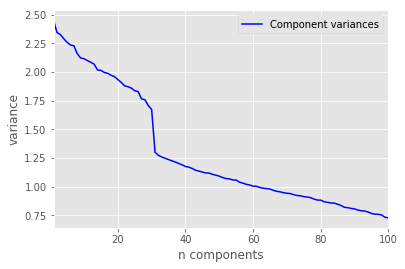

In [8]:
d_vars = np.array(sorted(variances, reverse=True))
plot_variances(d_vars)

In [9]:
diffs = [d_vars[i] - d_vars[i+1] for i in range(d_vars.size-1)]
dif_maps = zip(diffs, range(1, len(diffs)+1))
res_diffs = sorted(dif_maps)
write_answer_2(res_diffs[-1][1])

В качестве главных компонент мы получаем линейные комбинации исходных призанков, поэтому резонно возникает вопрос об их интерпретации.

Для этого существует несколько подходов, мы рассмотрим два:
- рассчитать взаимосвязи главных компонент с исходными признаками
- рассчитать вклады каждого конкретного наблюдения в главные компоненты

Первый способ подходит в том случае, когда все объекты из набора данных не несут для нас никакой семантической информации, которая уже не запечатлена в наборе признаков.

Второй способ подходит для случая, когда данные имеют более сложную структуру. Например, лица для человека несут больший семантический смысл, чем вектор значений пикселей, которые анализирует PCA.

Рассмотрим подробнее способ 1: он заключается в подсчёте коэффициентов корреляций между исходными признаками и набором главных компонент.

Так как метод главных компонент является линейным, то предлагается для анализа использовать корреляцию Пирсона, выборочный аналог которой имеет следующую формулу:

$$r_{jk} = \frac{\sum_{i=1}^N (x_{ij} - \bar{x}_j) (y_{ik} - \bar{y}_k)}{\sqrt{\sum_{i=1}^N (x_{ij} - \bar{x}_j)^2 \sum_{i=1}^N (y_{ik} - \bar{y}_k)^2}} $$

где:
- $\bar{x}_j$ -- среднее значение j-го признака,
- $\bar{y}_k$ -- среднее значение проекции на k-ю главную компоненту.


1. Обучим метод главных компонент на датасете iris, получите преобразованные данные.
2. Посчитаем корреляции исходных признаков с их проекциями на первые две главные компоненты.
3. Для каждого признака найдем компоненту (из двух построенных), с которой он коррелирует больше всего.

Набор данных состоит из 4 признаков, посчитанных для 150 ирисов. Каждый из них принадлежит одному из трёх видов. Визуализацию проекции данного датасета на две компоненты, которые описывают наибольшую дисперсию данных, можно получить при помощи функции

    plot_iris(transformed_data, target, target_names)
    
на вход которой требуется передать данные, преобразованные при помощи PCA, а также информацию о классах. Цвет точек отвечает одному из трёх видов ириса.

In [10]:
from sklearn import datasets

def plot_iris(transformed_data, target, target_names):
    plt.figure()
    for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
        plt.scatter(transformed_data[target == i, 0],
                    transformed_data[target == i, 1], c=c, label=target_name)
    plt.legend()
    plt.show()
    
def write_answer_3(list_pc1, list_pc2):
    with open("pca_answer3.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in list_pc1]))
        fout.write(" ")
        fout.write(" ".join([str(num) for num in list_pc2]))


iris = datasets.load_iris()
data = iris.data
target = iris.target
target_names = iris.target_names


In [11]:
model = PCA(n_components=2)
model.fit(data)
transformed = model.transform(data)

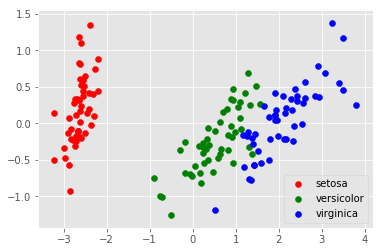

In [12]:
plot_iris(transformed, target, target_names)

In [13]:
def pearson_corr(w1, w2):
    m1 = w1.mean()
    m2 = w2.mean()
    w1_centered = w1 - m1
    w2_centered = w2 - m2
    return w1_centered.dot(w2_centered) / np.sqrt(((w1_centered.dot(w1_centered)) * (w2_centered.dot(w2_centered))))

In [14]:
r = np.zeros([data.shape[1], transformed.shape[1]])
for j in range(data.shape[1]):
    for k in range(transformed.shape[1]):
        r[j, k] = abs(pearson_corr(data[:, j], transformed[:, k]))

In [15]:
res1 = []
res2 = []
for i in range(r.shape[0]):
    if r[i, 0] >= r[i, 1]:
        res1.append(i+1)
    else:
        res2.append(i+1)

write_answer_3(res1, res2)

## Интерпретация главных компонент с использованием данных

Рассмотрим теперь величину, которую можно проинтерпретировать, как квадрат косинуса угла между объектом выборки и главной компонентой:

$$ cos^2_{ik} = \frac{(f_{ik} - \bar{f}_{k})^2}{\sum_{k=1}^d (f_{ik} - \bar{f}_{k})^2} $$

где
- i -- номер объекта
- k -- номер главной компоненты
- $f_{ik}$ -- модуль проекции объекта на компоненту

Очевидно, что

$$ \sum_{k=1}^d cos^2_{ik} = 1 $$

Это значит, что для каждого объекта мы в виде данной величины получили веса, пропорциональные вкладу, которую вносит данный объект в дисперсию каждой компоненты. Чем больше вклад, тем более значим объект для описания конкретной главной компоненты.

In [16]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import RandomizedPCA

def write_answer_4(list_pc):
    with open("pca_answer4.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in list_pc]))

data = fetch_olivetti_faces(shuffle=True, random_state=0).data
image_shape = (64, 64)

In [17]:
rpca = RandomizedPCA(n_components=10)
rpca.fit(data)
trans = rpca.transform(data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [18]:
import numpy as np
cos = np.zeros(trans.shape)
means = []
for k in range(trans.shape[1]):
    means.append(trans[:, k].mean())
    
for i in range(trans.shape[0]):
    noms = []
    denom = 0
    for k in range(trans.shape[1]):
        x = (abs(trans[i,k]) - means[k])**2
        denom += x
        noms.append(x)
    
    for k in range(trans.shape[1]):
        cos[i,k] = noms[k] / denom
        

In [19]:
result = []
for k in range(trans.shape[1]):
    result.append(max(zip(cos[:, k], range(cos.shape[0])))[1])

write_answer_4(result)